In [13]:
from scipy.io.wavfile import read, write
import torchaudio
import torch
from librosa.util import normalize
from librosa.filters import mel as librosa_mel_fn
import numpy as np
import librosa
import librosa.display
from tqdm import tqdm
import os
import soundfile as sf
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
MAX_WAV_VALUE = 32768.0

def load_wav(full_path):
    sampling_rate, data = read(full_path)
    return data, sampling_rate

def dynamic_range_compression(x, C=1, clip_val=1e-5):
    return np.log(np.clip(x, a_min=clip_val, a_max=None) * C)

def dynamic_range_decompression(x, C=1):
    return np.exp(x) / C

def dynamic_range_compression_torch(x, C=1, clip_val=1e-5):
    return torch.log(torch.clamp(x, min=clip_val) * C)

def dynamic_range_decompression_torch(x, C=1):
    return torch.exp(x) / C

def spectral_normalize_torch(magnitudes):
    output = dynamic_range_compression_torch(magnitudes)
    return output

def spectral_de_normalize_torch(magnitudes):
    output = dynamic_range_decompression_torch(magnitudes)
    return output

mel_basis = {}
hann_window = {}

def mel_spectrogram(y, n_fft, num_mels, sampling_rate, hop_size, win_size, fmin, fmax, center=False):
    if torch.min(y) < -1.:
        print('min value is ', torch.min(y))
    if torch.max(y) > 1.:
        print('max value is ', torch.max(y))

    global mel_basis, hann_window
    if fmax not in mel_basis:
        mel = librosa_mel_fn(sr=sampling_rate, n_fft=n_fft, n_mels=num_mels, fmin=fmin, fmax=fmax)
        mel_basis[str(fmax)+'_'+str(y.device)] = torch.from_numpy(mel).float().to(y.device)
        hann_window[str(y.device)] = torch.hann_window(win_size).to(y.device)

    y = torch.nn.functional.pad(y.unsqueeze(1), (int((n_fft-hop_size)/2), int((n_fft-hop_size)/2)), mode='reflect')
    y = y.squeeze(1)

    spec = torch.stft(y, n_fft, hop_length=hop_size, win_length=win_size, window=hann_window[str(y.device)],
                      center=center, pad_mode='reflect', normalized=False, onesided=True)

    spec = torch.sqrt(spec.pow(2).sum(-1)+(1e-9))

    spec = torch.matmul(mel_basis[str(fmax)+'_'+str(y.device)], spec)
    spec = spectral_normalize_torch(spec)

    return spec

In [44]:
data_path = "/blob/v-yuancwang/speech/audiocaps/audiocaps/train/audio_10s/dummy"
save_path = "/blob/v-yuancwang/audio_editing_data/audiocaps"
WAV_LENGTH = 16000 * 10 - 128
with open("/home/v-yuancwang/AudioEditing/metadatas/audiocaps_train_metadata.jsonl", "r") as f:
    lines = f.readlines()
lines = [eval(line) for line in lines]
for line in tqdm(lines[14500:]):
    file_name, text = line['file_name'], line['text']
    wav, sr = librosa.load(os.path.join(data_path, file_name), sr=16000)
    if len(wav) < WAV_LENGTH:
        wav = np.pad(wav, (0, WAV_LENGTH - len(wav)), 'constant', constant_values=(0, 0))
    wav = wav[: WAV_LENGTH]
    x = torch.FloatTensor(wav)
    # print(len(x))
    x = mel_spectrogram(x.unsqueeze(0), n_fft=1024, num_mels=80, sampling_rate=16000,
                    hop_size=256, win_size=1024, fmin=0, fmax=8000)
    # print(x.shape)
    spec = x.cpu().numpy()[0]
    # print(spec.shape)
    wav = wav * MAX_WAV_VALUE
    wav = wav.astype('int16')
    write(os.path.join(save_path, "wav", file_name), 16000, wav)
    np.save(os.path.join(save_path, "mel", file_name.replace(".wav", ".npy")), spec)

100%|██████████| 28806/28806 [2:22:13<00:00,  3.38it/s]  


In [7]:
data_path = "/blob/v-yuancwang/FSD50K/FSD50K.dev_audio"
save_path = "/blob/v-yuancwang/audio_editing_data/fsd50k"
WAV_LENGTH = 16000 * 10 - 128
wav_files = os.listdir(data_path)

  0%|          | 0/10 [00:00<?, ?it/s]

(80, 312)


 10%|█         | 1/10 [00:00<00:04,  2.15it/s]

(80, 624)


 20%|██        | 2/10 [00:01<00:04,  1.71it/s]

(80, 312)


 30%|███       | 3/10 [00:01<00:03,  2.12it/s]

(80, 312)


 40%|████      | 4/10 [00:01<00:02,  2.41it/s]

min value is  tensor(-1.1108)
(80, 312)


 50%|█████     | 5/10 [00:02<00:02,  2.44it/s]

(80, 624)


 60%|██████    | 6/10 [00:02<00:01,  2.09it/s]

(80, 312)


 80%|████████  | 8/10 [00:03<00:00,  2.46it/s]

(80, 312)
(80, 624)


100%|██████████| 10/10 [00:04<00:00,  2.18it/s]

(80, 312)


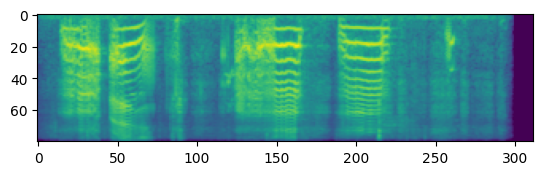

In [14]:
fsd_long, fsd_short = [], []
for file_name in tqdm(wav_files[:]):
    wav, sr = librosa.load(os.path.join(data_path, file_name), sr=16000)
    if len(wav) < WAV_LENGTH // 2:
        wav = np.pad(wav, (0, WAV_LENGTH // 2 - len(wav)), 'constant', constant_values=(0, 0))
        wav = wav[: WAV_LENGTH // 2]
        fsd_short.append(file_name)
    elif len(wav) < WAV_LENGTH:
        wav = np.pad(wav, (0, WAV_LENGTH - len(wav)), 'constant', constant_values=(0, 0))
        wav = wav[: WAV_LENGTH]
        fsd_long.append(file_name)
    else:
        wav = wav[: WAV_LENGTH]
        fsd_long.append(file_name)
    x = torch.FloatTensor(wav)
    # print(len(x))
    x = mel_spectrogram(x.unsqueeze(0), n_fft=1024, num_mels=80, sampling_rate=16000,
                    hop_size=256, win_size=1024, fmin=0, fmax=8000)
    # print(x.shape)
    spec = x.cpu().numpy()[0]
    # print(spec.shape)
    wav = wav * MAX_WAV_VALUE
    wav = wav.astype('int16')
    write(os.path.join(save_path, "wav", file_name), 16000, wav)
    np.save(os.path.join(save_path, "mel", file_name.replace(".wav", ".npy")), spec)

with open("/home/v-yuancwang/AudioEditing/metadatas/fsd50k_long.txt", "w") as f:
    for file_name in fsd_long:
        f.write(file_name + "/n")
with open("/home/v-yuancwang/AudioEditing/metadatas/fsd50k_short.txt", "w") as f:
    for file_name in fsd_short:
        f.write(file_name + "/n")

In [ ]:
# metadata = torchaudio.info("/home/v-yuancwang/AudioEditing/hifigan_test_wavs/--0w1YA1Hm4.wav")
# print(metadata)
# wav, sr = librosa.load("/home/v-yuancwang/AudioEditing/hifigan_test_wavs/--0w1YA1Hm4.wav", sr=16000)
# wav = wav * MAX_WAV_VALUE
# wav = wav.astype('int16')
# # write(os.path.join("/home/v-yuancwang/AudioEditing", "test.wav"), 16000, wav)
# sf.write(os.path.join("/home/v-yuancwang/AudioEditing", "test.wav"), wav, 16000)
# metadata = torchaudio.info(os.path.join("/home/v-yuancwang/AudioEditing", "test.wav"))
# print(metadata)